In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix


In [2]:
#import data
fraud = pd.read_csv('Fraud_check.csv')
fraud.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


## Data Preprocessing

In [4]:
fraud = fraud.rename(columns={'Marital.Status':'marital_status','Taxable.Income':'tax_income','City.Population':'population','Work.Experience':'work_exp'} )
fraud.head()

,Undergrad,marital_status,tax_income,population,work_exp,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [5]:
fraud.drop('population',axis=1,inplace = True)

In [6]:
#encoding the categorical variables
encoder = preprocessing.LabelEncoder()
fraud['Undergrad'] = encoder.fit_transform(fraud['Undergrad'])
fraud['marital_status'] = encoder.fit_transform(fraud['marital_status'])
fraud['Urban'] = encoder.fit_transform(fraud['Urban'])

fraud.head()

,Undergrad,marital_status,tax_income,work_exp,Urban
0,0,2,68833,10,1
1,1,0,33700,18,1
2,0,1,36925,30,1
3,1,2,50190,15,1
4,0,1,81002,28,0


In [7]:
fraud['risky']=''
fraud.loc[fraud['tax_income']<=30000,'risky']='1'
fraud.loc[fraud['tax_income']>30000,'risky']='0'

fraud.head()


,Undergrad,marital_status,tax_income,work_exp,Urban,risky
0,0,2,68833,10,1,0
1,1,0,33700,18,1,0
2,0,1,36925,30,1,0
3,1,2,50190,15,1,0
4,0,1,81002,28,0,0


In [8]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Undergrad       600 non-null    int32 
 1   marital_status  600 non-null    int32 
 2   tax_income      600 non-null    int64 
 3   work_exp        600 non-null    int64 
 4   Urban           600 non-null    int32 
 5   risky           600 non-null    object
dtypes: int32(3), int64(2), object(1)
memory usage: 21.2+ KB


In [9]:
fraud.drop('tax_income',axis=1,inplace = True)

In [10]:
fraud['risky'].value_counts()

0    476
1    124
Name: risky, dtype: int64

#### The data is clearly imbalanced.

In [11]:
Y = fraud.iloc[:,-1]
X = fraud.iloc[:,0:-1]

In [12]:
# Splitting data into training and testing data set
x_train, x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2,random_state=40)

## Random Forest Classification-  hyperparameter tuning using Gridsearch

In [13]:
parameters = [{'n_estimators':[10, 20,100], 
              'max_depth':range(2,10),
               'max_features': [3]
             }]

clf_tree = RandomForestClassifier()
clf = GridSearchCV(clf_tree,parameters,cv=5,scoring = 'roc_auc')

In [14]:
#fitting the model
clf.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': range(2, 10), 'max_features': [3],
                          'n_estimators': [10, 20, 100]}],
             scoring='roc_auc')

In [15]:
clf.best_score_

0.4916772043745728

The best accuracy score is 0.475 , which is not good.

In [16]:
clf.best_params_

{'max_depth': 2, 'max_features': 3, 'n_estimators': 10}

Since, best parameters are max_depth =2 with maximum features 3 with 10 decision trees,  we will build the final model with optimal parameter values.

## Building Model with optimal parameters

In [17]:
clf_randf = RandomForestClassifier(n_estimators = 10, max_depth = 2,max_features = 3)

In [18]:
clf_randf.fit(x_train,y_train)

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=10)

In [19]:
y_pred = clf_randf.predict(x_test)
test_results = pd.DataFrame({'actual':y_test,'predicted':y_pred})
test_results.head()

,actual,predicted
159,0,0
307,0,0
253,0,0
528,0,0
137,1,0


## Measuring Test Acuuracy

In [20]:
roc_auc_score(y_test,y_pred)

0.5

### Confusion Matrix

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[92,  0],
       [28,  0]], dtype=int64)

### Classification Report

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        92
           1       0.00      0.00      0.00        28

    accuracy                           0.77       120
   macro avg       0.38      0.50      0.43       120
weighted avg       0.59      0.77      0.67       120



C:\Users\Debanjali\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Feature Selection

<AxesSubplot:xlabel='importance', ylabel='feature'>

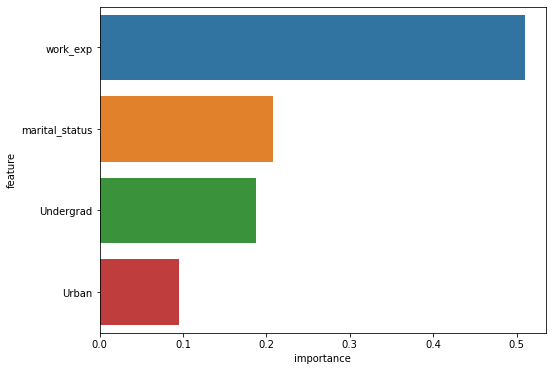

In [23]:
feature_rank = pd.DataFrame({'feature': x_train.columns,
                            'importance': clf_randf.feature_importances_})

feature_rank = feature_rank.sort_values('importance',ascending = False)
plt.figure(figsize=(8,6))
sn.barplot(y='feature',x='importance',data = feature_rank)

In [24]:
feature_rank.importance

2    0.509617
1    0.207295
0    0.187899
3    0.095189
Name: importance, dtype: float64

we can see that work_exp is the best feature,it alone explains 60 % of information in the data w.r.t the target variable. The top # features together explains almost 96% of the information. Urban is the worst feature here.

## Final Conclusions

1. In the model, the training-set accuracy score is 0.475 while the test-set accuracy to be 0.5. These two values are quite comparable. So, there is no sign of overfitting.
2. From the confusion matrix we see that it predicts the good class perfectly but cannot predict the risk class at all.
3. From the classification report we see that the recall for 0 is 1 and for 1 it is 0, thus proving the previous point. This could be due to an imbalanced dataset.

Finally, if we compare it with the Decision tree model ,we made previously on the same data,we see the results haven't improved. This could be again due the imbalanced data.